**Importing required libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy import sparse
from spreg import ML_Lag, ML_Error
from libpysal.weights.util import get_points_array_from_shapefile
from libpysal.weights import Queen
import geopandas as gpd
from libpysal import weights
import matplotlib.pyplot as plt
import contextily as ctx
import libpysal as lps
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import pysal.lib
import pysal.model.spreg
from pysal.model.spreg import GM_Error_Het
from pysal.lib import weights

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Library/Frameworks/Python.framework/

**Importing the datasets**: 
Assigning the file paths of call detail records, remote sensing data, and principle component analysis data to mobile_path, satellite_path, and pca_path respectively

In [4]:
mobile_path = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/mobile_features.csv'
satellite_path = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/satellite_features.csv'
pca_path = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/pca_census.csv'

# **Data Cleaning**

In [5]:
#Reading Ground truth DATA and filtering zero population gnds (Grama niladhari divisions are referred to as gnd, which are the smallest diviions in Sri Lanka)
data_pca = pd.read_csv(pca_path)
missing_gnd_ids = data_pca.loc[data_pca['PC1'].isnull(), 'gnd_id']
count = missing_gnd_ids.count()
print('No of gnds with zero population:',count)

No of gnds with zero population: 37


In [6]:
# Read the datasets and merge into a single pandas dataframe
data_raw = pd.read_csv(mobile_path).merge(pd.read_csv(satellite_path), on='gnd_id').merge(pd.read_csv(pca_path), on='gnd_id').rename(columns={"PC1": "pc_1"}).set_index('gnd_id')

In [7]:
#Removing the zero population gnds from the dataframe
data_raw = data_raw[~data_raw.index.isin(missing_gnd_ids)]

# **Data Processing**

In [8]:
# Log transform skewed variables
data_unskewed = data_raw[[

    #Call detail records
    "call_count",
    "avg_call_duration",
    "nighttime_call_count",
    "avg_nighttime_call_duration",
    "incoming_call_count",
    "avg_incoming_call_duration",
    "radius_of_gyration",
    "unique_tower_count",
    "spatial_entropy",
    "avg_call_count_per_contact",
    "avg_call_duration_per_contact",
    "contact_count",
    "social_entropy",

    #Remote Sensing data
    "travel_time_major_cities",
    "population_count_worldpop",
    "population_count_ciesin",
    "population_density",
    "aridity_index",
    "evapotranspiration",
    "nighttime_lights",
    "elevation",
    "vegetation",
    "distance_roadways_motorway",
    "distance_roadways_trunk",
    "distance_roadways_primary",
    "distance_roadways_secondary",
    "distance_roadways_tertiary",
    "distance_waterways",
    "urban_rural_fb",
    "urban_rural_ciesin",
    "global_human_settlement",
    "protected_areas",
    "land_cover_woodland",
    "land_cover_grassland",
    "land_cover_cropland",
    "land_cover_wetland",
    "land_cover_bareland",
    "land_cover_urban",
    "land_cover_water",
    "pregnancies",
    "births",
    "precipitation",
    "temperature",

    #principle componanet analysis
    "pc_1"
]].copy()

# Log transform skewed variables
data_unskewed.loc[:, "radius_of_gyration_log"] = np.log(data_unskewed["radius_of_gyration"])
data_unskewed.loc[:, "travel_time_major_cities_log"] = np.log(data_unskewed["travel_time_major_cities"] + 1)
data_unskewed.loc[:, "population_count_worldpop_log"] = np.log(data_unskewed["population_count_worldpop"] + 1)
data_unskewed.loc[:, "population_count_ciesin_log"] = np.log(data_unskewed["population_count_ciesin"] + 1)
data_unskewed.loc[:, "population_density_log"] = np.log(data_unskewed["population_density"])
data_unskewed.loc[:, "elevation_log"] = np.log(data_unskewed["elevation"] + 1)
data_unskewed.loc[:, "distance_roadways_trunk_log"] = np.log(data_unskewed["distance_roadways_trunk"] + 1)
data_unskewed.loc[:, "distance_roadways_primary_log"] = np.log(data_unskewed["distance_roadways_primary"] + 1)
data_unskewed.loc[:, "distance_roadways_secondary_log"] = np.log(data_unskewed["distance_roadways_secondary"] + 1)
data_unskewed.loc[:, "distance_roadways_tertiary_log"] = np.log(data_unskewed["distance_roadways_tertiary"] + 1)
data_unskewed.loc[:, "distance_waterways_log"] = np.log(data_unskewed["distance_waterways"] + 1)
data_unskewed.loc[:, "urban_rural_fb_log"] = np.log(data_unskewed["urban_rural_fb"] + 1)
data_unskewed.loc[:, "global_human_settlement_log"] = np.log(data_unskewed["global_human_settlement"] + 1)
data_unskewed.loc[:, "protected_areas_log"] = np.log(data_unskewed["protected_areas"] + 1)
data_unskewed.loc[:, "land_cover_grassland_log"] = np.log(data_unskewed["land_cover_grassland"] + 1)
data_unskewed.loc[:, "land_cover_wetland_log"] = np.log(data_unskewed["land_cover_wetland"] + 1)
data_unskewed.loc[:, "land_cover_bareland_log"] = np.log(data_unskewed["land_cover_bareland"] + 1)
data_unskewed.loc[:, "land_cover_water_log"] = np.log(data_unskewed["land_cover_water"] + 1)
data_unskewed.loc[:, "pregnancies_log"] = np.log(data_unskewed["pregnancies"])
data_unskewed.loc[:, "births_log"] = np.log(data_unskewed["births"])

'''
#Optional step, consider rs_only variable when conducting the study only with remote sensing data
rs_only = data_unskewed[[
    "travel_time_major_cities_log",
    "population_count_worldpop_log",
    "population_count_ciesin_log",
    "population_density_log",
    "aridity_index",
    "evapotranspiration",
    "nighttime_lights",
    "elevation_log",
    "vegetation",
    "distance_roadways_motorway",
    "distance_roadways_trunk_log",
    "distance_roadways_primary_log",
    "distance_roadways_secondary_log",
    "distance_roadways_tertiary_log",
    "distance_waterways_log",
    "urban_rural_fb_log",
    "urban_rural_ciesin",
    "global_human_settlement_log",
    "protected_areas_log",
    "land_cover_woodland",
    "land_cover_grassland_log",
    "land_cover_cropland",
    "land_cover_wetland_log",
    "land_cover_bareland_log",
    "land_cover_urban",
    "land_cover_water_log",
    "pregnancies_log",
    "births_log",
    "precipitation",
    "temperature",

    #principle componanet analysis
    "pc_1"
]].copy()

#Optional step, consider cdr_only variable when conducting the study only with call detail records

cdr_only = data_unskewed[[
"call_count",
    "avg_call_duration",
    "nighttime_call_count",
    "avg_nighttime_call_duration",
    "incoming_call_count",
    "avg_incoming_call_duration",
    "radius_of_gyration",
    "unique_tower_count",
    "spatial_entropy",
    "avg_call_count_per_contact",
    "avg_call_duration_per_contact",
    "contact_count",
    "social_entropy",
    #principle componanet analysis
    "pc_1" 
]].copy()

#data_unskewed = rs_only.copy()

'''

'\n#Optional step, consider rs_only variable when conducting the study only with remote sensing data\nrs_only = data_unskewed[[\n    "travel_time_major_cities_log",\n    "population_count_worldpop_log",\n    "population_count_ciesin_log",\n    "population_density_log",\n    "aridity_index",\n    "evapotranspiration",\n    "nighttime_lights",\n    "elevation_log",\n    "vegetation",\n    "distance_roadways_motorway",\n    "distance_roadways_trunk_log",\n    "distance_roadways_primary_log",\n    "distance_roadways_secondary_log",\n    "distance_roadways_tertiary_log",\n    "distance_waterways_log",\n    "urban_rural_fb_log",\n    "urban_rural_ciesin",\n    "global_human_settlement_log",\n    "protected_areas_log",\n    "land_cover_woodland",\n    "land_cover_grassland_log",\n    "land_cover_cropland",\n    "land_cover_wetland_log",\n    "land_cover_bareland_log",\n    "land_cover_urban",\n    "land_cover_water_log",\n    "pregnancies_log",\n    "births_log",\n    "precipitation",\n    "t

In [9]:
data_unskewed = data_unskewed.drop(columns=["radius_of_gyration", "travel_time_major_cities", "population_count_worldpop", "population_count_ciesin", "population_density", "elevation", "distance_roadways_trunk", "distance_roadways_primary", "distance_roadways_secondary", "distance_roadways_tertiary", "distance_waterways", "urban_rural_fb", "global_human_settlement", "protected_areas", "land_cover_grassland", "land_cover_wetland", "land_cover_bareland", "land_cover_water", "pregnancies", "births"])

In [10]:
#fill missing values with their mean
data_unskewed.fillna(data_unskewed.mean(), inplace=True)
data_unskewed.isna().sum()

call_count                         0
avg_call_duration                  0
nighttime_call_count               0
avg_nighttime_call_duration        0
incoming_call_count                0
avg_incoming_call_duration         0
unique_tower_count                 0
spatial_entropy                    0
avg_call_count_per_contact         0
avg_call_duration_per_contact      0
contact_count                      0
social_entropy                     0
aridity_index                      0
evapotranspiration                 0
nighttime_lights                   0
vegetation                         0
distance_roadways_motorway         0
urban_rural_ciesin                 0
land_cover_woodland                0
land_cover_cropland                0
land_cover_urban                   0
precipitation                      0
temperature                        0
pc_1                               0
radius_of_gyration_log             0
travel_time_major_cities_log       0
population_count_worldpop_log      0
p

**Data stratification based on Province**

In [10]:
province = data_unskewed.index.astype(str).str[0]
X_train, X_test, y_train, y_test = train_test_split(data_unskewed.drop(columns=["pc_1"]), data_unskewed["pc_1"], stratify=province, test_size=0.2)

In [11]:
# Normalize and remove highly correlated and near-zero variance variables
scaler_train = StandardScaler()
data_train_scaled = scaler_train.fit_transform(X_train)

scaler_test = StandardScaler()
data_test_scaled = scaler_test.fit_transform(X_test)

scaler_full = StandardScaler()
data_full_scaled = scaler_full.fit_transform(data_unskewed.drop(columns="pc_1"))

# Convert the scaled data back to a DataFrame
data_full_scaled = pd.DataFrame(data_full_scaled, columns=data_unskewed.columns.drop("pc_1"))
data_full_scaled["pc_1"] = data_unskewed["pc_1"]

data_train_scaled = pd.DataFrame(data_train_scaled, columns=X_train.columns)
data_train_scaled.index = X_train.index


data_test_scaled = pd.DataFrame(data_test_scaled, columns=X_test.columns)
data_test_scaled.index = X_test.index

**Loading the Sri Lanka shapefile**

In [11]:
data_shapefile = gpd.read_file("/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/sri_lanka_gnd_shape_files/colombo.shp")

#In the shape file, code_7 column corresponds to the gnd id
data_shapefile.set_index("code_7", inplace=True)

In [12]:
data_shapefile

,prov_name,dist_name,dsd_name,gnd_name,geometry
code_7,,,,,
1115280,Western,Colombo,Seethawaka,Jayaweeragoda,"POLYGON ((397753.428 762939.817, 397746.381 76..."
1115285,Western,Colombo,Seethawaka,Koodaluvila,"POLYGON ((397301.449 761032.288, 397295.839 76..."
1115330,Western,Colombo,Seethawaka,Thunnana West,"POLYGON ((398714.619 760946.625, 398724.096 76..."
1115335,Western,Colombo,Seethawaka,Mawathagama West,"POLYGON ((398611.829 759900.033, 398607.056 75..."
1115205,Western,Colombo,Seethawaka,Hanwella Town,"POLYGON ((399924.334 764292.097, 399969.770 76..."
...,...,...,...,...,...
1136290,Western,Colombo,Kesbewa,Batakettara South,"POLYGON ((381610.214 749967.819, 381591.792 74..."
1136285,Western,Colombo,Kesbewa,Kesbewa South,"POLYGON ((382216.052 750768.320, 382229.378 75..."
1136315,Western,Colombo,Kesbewa,Makandana west,"POLYGON ((383247.933 748806.434, 383228.121 74..."


**Merge the shape file with the dataframe**

In [13]:
data_shapefile = data_shapefile.to_crs(epsg=3857)
merged = data_unskewed.merge(data_shapefile, left_on=data_unskewed.index, right_on='code_7', how='inner')

In [14]:
merged

,code_7,call_count,avg_call_duration,nighttime_call_count,avg_nighttime_call_duration,incoming_call_count,avg_incoming_call_duration,unique_tower_count,spatial_entropy,avg_call_count_per_contact,...,land_cover_wetland_log,land_cover_bareland_log,land_cover_water_log,pregnancies_log,births_log,prov_name,dist_name,dsd_name,gnd_name,geometry
0,1103005,2983.347272,109.736455,258.273202,158.339897,1394.390617,108.199741,67.281489,0.386727,13.067985,...,0.0,0.0,0.00000,3.793410,3.407934,Western,Colombo,Colombo,Sammanthranapura,"POLYGON ((8891903.546 778340.051, 8891876.960 ..."
1,1103010,3115.096453,113.275011,256.420453,165.039452,1454.389404,111.778611,68.324745,0.386224,13.588289,...,0.0,0.0,0.09531,7.302625,6.917149,Western,Colombo,Colombo,Mattakkuliya,"POLYGON ((8891588.324 778696.317, 8891623.033 ..."
2,1103015,3271.991912,113.882146,272.819563,167.605376,1535.191949,112.623913,68.665852,0.371180,14.316651,...,0.0,0.0,0.00000,6.363817,5.978341,Western,Colombo,Colombo,Modara,"POLYGON ((8890828.772 777806.715, 8890829.232 ..."
3,1103020,2986.160123,112.830805,254.428356,163.728059,1400.083580,111.454820,65.247871,0.391208,13.878327,...,0.0,0.0,0.00000,5.310735,4.925259,Western,Colombo,Colombo,Madampitiya,"POLYGON ((8891529.735 776549.660, 8891511.091 ..."
4,1103025,2742.650735,109.498520,255.465969,156.282917,1284.386005,106.600350,61.698145,0.391679,13.397243,...,0.0,0.0,0.00000,5.988538,5.603062,Western,Colombo,Colombo,Mahawatta,"POLYGON ((8891136.015 776838.685, 8891221.430 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,1136345,2399.674440,115.462381,163.395522,163.764461,1123.305970,117.039273,81.796642,0.445504,13.458728,...,0.0,0.0,0.00000,2.457658,2.072182,Western,Colombo,Kesbewa,Batuwandara South,"POLYGON ((8898727.389 755057.639, 8898775.329 ..."
553,1136350,2250.227563,115.723064,153.395995,163.036516,1052.199583,116.330008,77.374975,0.448520,13.039118,...,0.0,0.0,0.00000,3.732378,3.346902,Western,Colombo,Kesbewa,Jamburaliya,"POLYGON ((8898727.389 755057.639, 8898812.677 ..."
554,1136355,2438.117373,113.223832,171.712373,161.078600,1158.654401,113.025314,75.991262,0.414113,13.496102,...,0.0,0.0,0.00000,2.469212,2.083736,Western,Colombo,Kesbewa,Polhena,"POLYGON ((8898499.233 755049.572, 8898455.658 ..."
555,1136360,2439.273126,113.156532,171.962412,160.997851,1159.717120,112.904638,75.816728,0.413169,13.497225,...,0.0,0.0,0.00000,2.388473,2.002997,Western,Colombo,Kesbewa,Regidel watta,"POLYGON ((8898031.494 754203.101, 8898036.400 ..."


In [13]:
gdf = gpd.GeoDataFrame(merged, geometry='geometry', crs=data_shapefile.crs)
gdf = gdf.to_crs(epsg=3857)

In [14]:
gnds = gdf['code_7']

data_unskewed = data_unskewed[data_unskewed.index.isin(gnds)]

**The Sri Lankan map**: Red indicates gnds with population, while gray indicates the gnds with zero population

(8885450.653950201, 8932310.103549933, 747752.1510370603, 780507.9002013176)

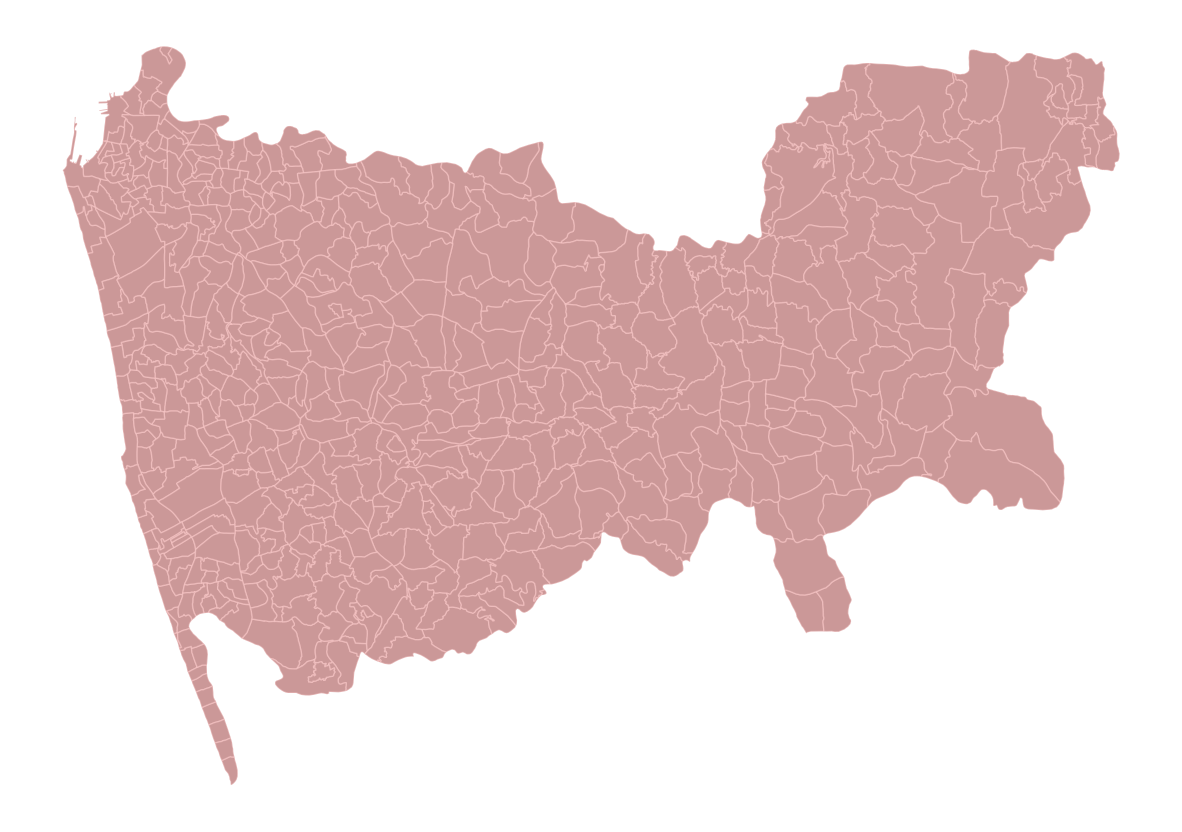

In [15]:
fig, ax = plt.subplots(1,1,figsize=(15, 15))

data_shapefile.plot(ax=ax,
        color='gray', 
        edgecolor='white',
        alpha=0.5)

gdf.plot(ax=ax, 
            color='red',
            markersize=1,
            alpha=0.2)

ax.axis('off')

# Ground Truth Map

Data obtained from principle component analysis

Text(0.5, 1.0, 'Ground truth map')

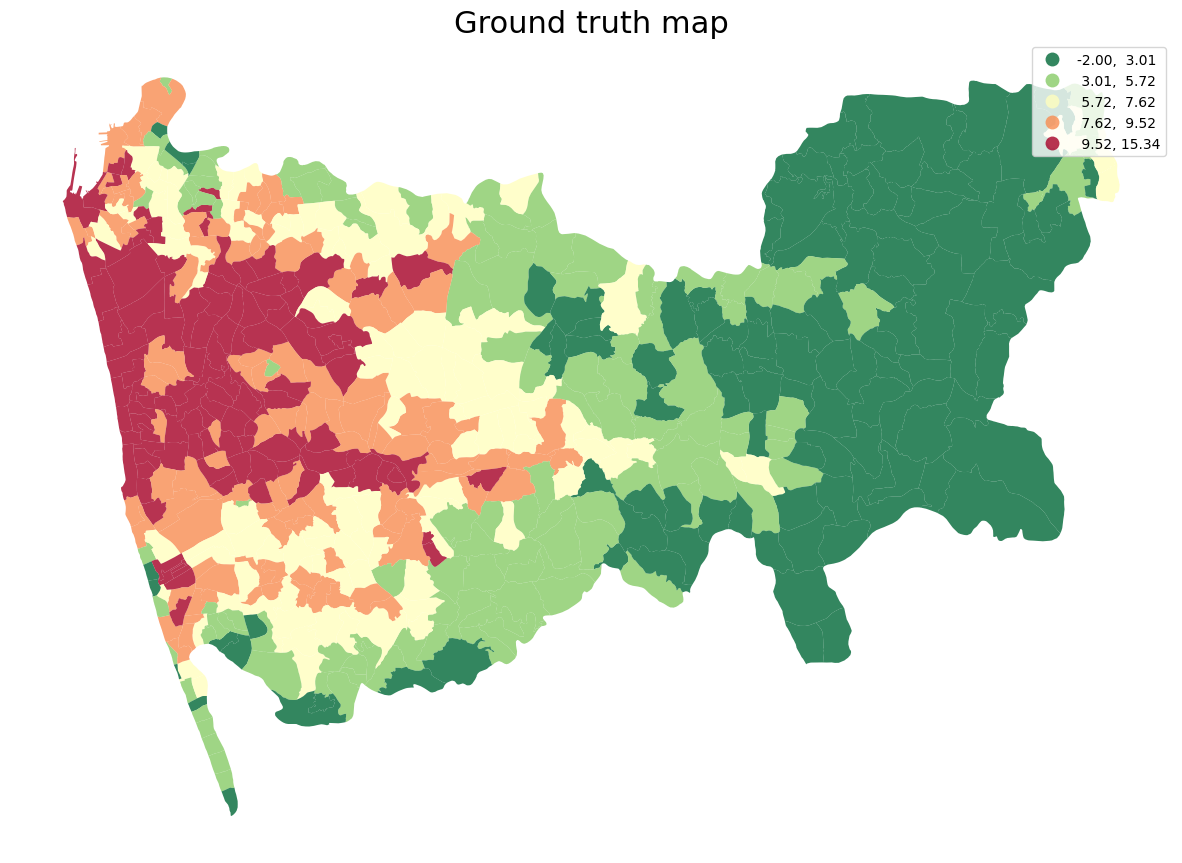

In [33]:
fig,ax = plt.subplots(figsize=(15,15))

gdf.plot(ax=ax,
        column='pc_1',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles') 

ax.axis('off')
ax.set_title('Ground truth map',fontsize=22)

In [80]:
# calculating the spatial weight (impact from the nearest eight gnds)

wq =  lps.weights.KNN.from_dataframe(gdf,k=8)

# Row-standardization
#wq.transform = 'r'

In [81]:
# create a new column for the spatial lag (spatial autocorrelation)
gdf['spatial_lag'] = lps.weights.lag_spatial(wq, gdf['population_density_log'])

# **Modeling**

# Ordinary Least Squares Model

In [20]:
X_train = sm.add_constant(data_train_scaled)
model = sm.OLS(y_train, X_train)
model_OLS = model.fit()

print(model_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                   pc_1   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     818.4
Date:                Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                        21:57:28   Log-Likelihood:                -21312.
No. Observations:               11188   AIC:                         4.271e+04
Df Residuals:                   11144   BIC:                         4.303e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In general, our model performs well, with a R squared value of 0.759. Since OLS models assumes independence of observations, which can lead to biased estimates and incorrect inferences in spatial data. Therefore Spatial models are preferred over OLS when studying spatial distribution because they account for spatial autocorrelation, where nearby locations tend to influence each other. Spatial models, like spatial lag or error models, and Spatial Durbin error models, consider this interdependence, enhancing our understanding of how spatial patterns influence the variable of interest and leading to more accurate and robust analyses, even if OLS provides a high R-squared value.
 

# Spatial Error Model (SEM)

In [90]:
y = data_unskewed['pc_1'].values
X = data_unskewed.drop(['pc_1', ], axis=1).values

# SEM model
sem_model = pysal.model.spreg.GM_Error(y, X, w=wq, name_y='pc_1', name_x=data_unskewed.columns.drop('pc_1').tolist())
print(sem_model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :        pc_1                Number of Observations:         557
Mean dependent var  :      6.4162                Number of Variables   :          29
S.D. dependent var  :      3.4591                Degrees of Freedom    :         528
Pseudo R-squared    :      0.1187

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    384211.1132963             nan             nan             nan
travel_time_major_cities_log       2.9667541       0.7454041       3.9800612       0.0000689
population_count_worldpop_log       0.3562028       0.9559896       0.3726011    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/spreg/error_sp.py:122: RuntimeWarning: invalid value encountered in sqrt
  se_betas = np.sqrt(self.vm.diagonal())
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/spreg/diagnostics.py:352: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/spreg/diagnostics.py:167: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(variance)


# Spatial Lag Error Model (SLX)

In [86]:
# SLX model
slx_model = pysal.model.spreg.ML_Lag(y, X, w=wq, name_y='pc_1', name_x=data_unskewed.columns.drop('pc_1').tolist())
print(slx_model.summary)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/spreg/ml_lag.py:608: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :        pc_1                Number of Observations:         557
Mean dependent var  :      6.4162                Number of Variables   :          29
S.D. dependent var  :      3.4591                Degrees of Freedom    :         528
Pseudo R-squared    :      0.8224
Spatial Pseudo R-squared:  0.5775
Sigma-square ML     :       2.170                Log likelihood        :   -1053.302
S.E of regression   :       1.473                Akaike info criterion :    2164.603
                                                 Schwarz criterion     :    2289.958

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

# Spatial Durbin Error Model (SDEM)

In [82]:
y = data_unskewed['pc_1'].values
X = data_unskewed.drop(columns='pc_1').values

model_SDEM = GM_Error_Het(y, X, w=wq, name_y='pc_1', name_x=data_unskewed.columns.drop('pc_1').tolist())
print(model_SDEM.)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :        pc_1                Number of Observations:         557
Mean dependent var  :      6.4162                Number of Variables   :          28
S.D. dependent var  :      3.4591                Degrees of Freedom    :         529
Pseudo R-squared    :      0.4652
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    -207559.2500000    1511674.6126508      -0.1373042       0.8907904
travel_time_major_cities_log      -0.5401662       0.4165345      -1.2968

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/spreg/diagnostics.py:352: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/spreg/diagnostics.py:167: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(variance)


# Model Comparison (SEM VS SLX VS SDEM)

**The most common statistical methods to compare spatial models**

1. **Akaike Information Criterion (AIC)** : A lower AIC value generally indicates a better model.
2.  **Bayesian Information Criterion (BIC)**: A lower BIC value generally indicates a better model.
3. **Log-Likelihood** : This is a measure of how well the model explains the data. Higher log-likelihood values indicate a better fit.


**Computation**

AIC (Akaike Information Criterion) = 2k - 2ln(L)

BIC (Bayesian Information Criterion) = kln(n) - 2ln(L)

where,

k is the number of parameters
L is the maximized value of the likelihood function of the model
n is the number of observations

In [261]:
# residuals for SEM model
residuals_sem = sem_model.y - sem_model.predy
# residuals for SLX model
residuals_slx = slx_model.y - slx_model.predy

# Log-Likelihood for SEM
mse_sem = mean_squared_error(sem_model.y.flatten(), sem_model.predy.flatten())
llf_sem = -0.5 * len(sem_model.y) * np.log(2 * np.pi * mse_sem) - 0.5 * np.sum(np.array(residuals_sem)**2) / mse_sem

# Log-Likelihood for SLX
mse_slx = mean_squared_error(slx_model.y.flatten(), slx_model.predy.flatten())
llf_slx = -0.5 * len(slx_model.y) * np.log(2 * np.pi * mse_slx) - 0.5 * np.sum(np.array(residuals_slx)**2) / mse_slx

k_sem = len(sem_model.betas)
k_slx = len(slx_model.betas)

aic_sem = 2.0*k_sem - 2*llf_sem

bic_sem = np.log(len(sem_model.y))*k_sem - 2*llf_sem

aic_slx = 2.0*k_slx - 2*llf_slx

bic_slx = np.log(len(slx_model.y))*k_slx - 2*llf_slx


In [262]:
# residuals for SDEM model
residuals_sdem = model_SDEM.y - model_SDEM.predy

mse_sdem = mean_squared_error(model_SDEM.y.flatten(), model_SDEM.predy.flatten())

llf_sdem = -0.5 * len(model_SDEM.y) * np.log(2 * np.pi * mse_sdem) - 0.5 * np.sum(np.array(residuals_sdem)**2) / mse_sdem

k_sdem = len(model_SDEM.betas)

aic_sdem = 2.0*k_sdem - 2*llf_sdem


bic_sdem = np.log(len(model_SDEM.y))*k_sdem - 2*llf_sdem

In [264]:
print('AIC')
print('SEM AIC: ', aic_sem)
print('SLX AIC: ', aic_slx)
print('SDEM AIC: ', aic_sdem)


print('BIC')
print('SEM BIC: ', bic_sem)
print('SLX BIC: ', bic_slx)
print('SDEM BIC: ', bic_sdem)


AIC
SEM AIC:  101130.87418715494
SLX AIC:  51786.79776257428
SDEM AIC:  66594.84024261468
BIC
SEM BIC:  101244.06029623948
SLX BIC:  51899.98387165882
SDEM BIC:  66708.02635169921


**Selection**

According to these criteria, SLX model appears to be the best performing model. However, since we are more interested in **Spatial error effect** rather than **Spatial lag effect** the selection among SEM or SDEM model is more appropriate. So considering the above AIC/ BIC criteria, SDEM model is selected as the best performing model.



In [87]:
data_unskewed['pred_pc_1'] = model_SDEM.predy.flatten()

Text(0.5, 1.0, 'SDEM model map')

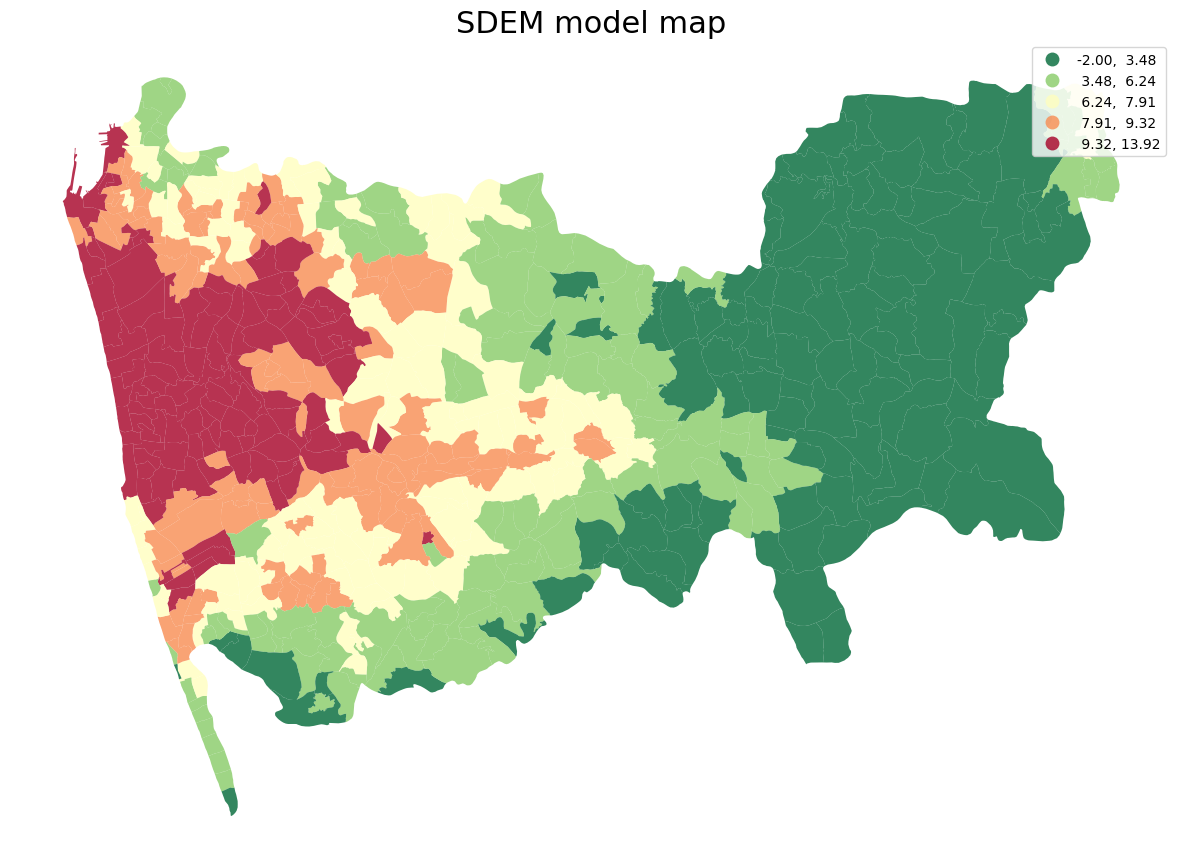

In [88]:
merged = data_unskewed.merge(data_shapefile, left_on=data_unskewed.index, right_on='code_7', how='inner')
gdf = gpd.GeoDataFrame(merged, geometry='geometry', crs=data_shapefile.crs)
gdf = gdf.to_crs(epsg=3857)

fig,ax = plt.subplots(figsize=(15,15))

gdf.plot(ax=ax,
        column='pred_pc_1',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles') 

ax.axis('off')
ax.set_title('SDEM model map',fontsize=22)

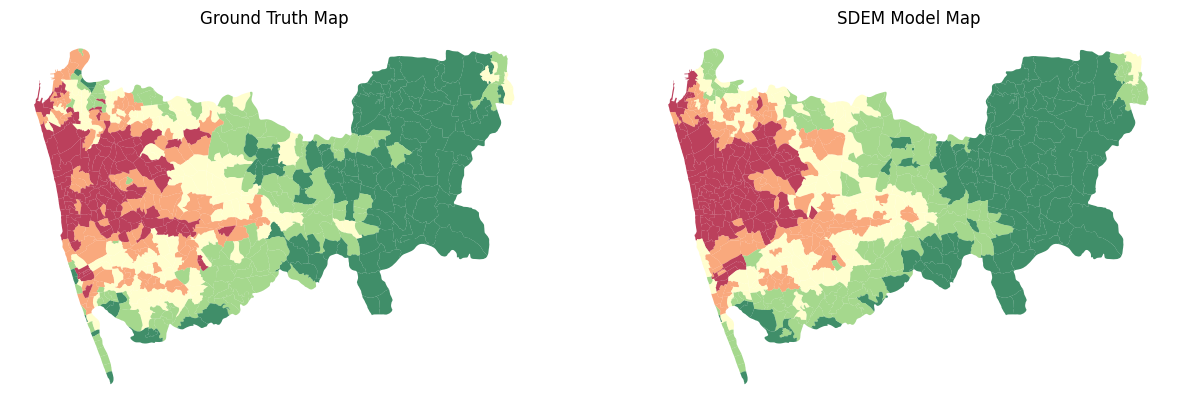

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

gdf.plot(ax=ax[0],
         column='pc_1', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Ground Truth Map")


gdf.plot(ax=ax[1],
         column='pred_pc_1', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("SDEM Model Map")

plt.show()

Prediction of top 50%

In [29]:
top_25_percent = int(0.5 * len(gdf))
df_top_25 = df_sorted.iloc[:top_25_percent]

index_values_top_25 = df_top_25.index.values

df_top_25 = gdf.loc[index_values_top_25]

actual_values = df_top_25['pc_1']
predicted_values = df_top_25['pred_pc_1']


r2 = r2_score(actual_values, predicted_values)

r2

0.5172977117397757